In [1]:
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
import re
import os
from IPython.display import Image 
import cv2
from tempfile import TemporaryFile
from scipy import stats
from torchvision import transforms
import pandas as pd
import shutil
import datetime
import glob
from scipy import integrate
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import ImageFile, Image
import sys
sys.path.insert(1, '../architecture')
sys.path.insert(2, '../dataLoaders')
from ProUNet import *
import torchvision.models as models
from MapillaryDataLoader import *
from volvoDataLoader_onFly import *
from VolvoDataLoader import *
from tqdm import tqdm
from torchsummary import summary
#from MapRSCD import *
%matplotlib inline

2024-07-31 21:05:58.147122: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def singleFrame(vid_add, indexFrame):
    
    filename = glob.glob(os.path.join(vid_add,"*.mp4"))[0]
    cap = cv2.VideoCapture(filename)
    cap.set(1, indexFrame)
    ret, frame = cap.read()


    cap.release()
    cv2.destroyAllWindows()
    
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [3]:
season = "Winter"
date = "23-03-2021"
hour = "15:58"
year = "2021"
vid_add = "/media/wsmo6/SSD1T/{}Test{}/sorted/{}".format(season, year, date + "_" + hour)

In [4]:
transform_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4191, 0.4586, 0.4700], [0.2553, 0.2675, 0.2945]),
    transforms.Resize((256,256))
])
transform_ou = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

In [5]:
#mapil_tr = MapRSCD(datasetRootPath = '../../../datasets/augmented_mapillary', mapillaryConfigFileAdd = "../../../datasets/mapillary", mode = 'train', imgSize = (256,256))
args = {
    "mode":"train",
    "input_img_dim":(256,256),
    "mapillaryRootPath":'../../../datasets/augmented_mapillary',
    "cityscapesRootPath":'../../../datasets/augmented_cityscapes',
    "RSCDRootPath":'../../../datasets/RSCD',
    "volvoRootPath":"../../../datasets/VolvoAnnotatedImages/rawDataset/images",
    "reducedCategories":True
}

dataloader = volvo_onFly(**args)

# dataloader = mapillaryDataLoader(**{"mapillaryRootPath":'../../../datasets/augmented_mapillary', "mode":"train", "input_img_dim": (256,256), "reducedCategories":{"enable":True}})

device = torch.device('cpu')
model = ProUNet(gecoConfig = {"enable":False}, device = device, num_classes = dataloader.get_num_classes(), LatentVarSize = 6, beta = 3, training = True, num_samples = 16)
#### summary(model, [(3,256,256), (8,256,256), (1,256,256)], device = "cpu")
model(torch.rand(size = (1,3,256,256)), torch.rand(size = (1,8,256,256)), torch.rand(size = (1,1,256,256)))

In [6]:
device = torch.device('cuda:1')
model = ProUNet(gecoConfig = {"enable":False}, device = device, num_classes = dataloader.get_num_classes(), LatentVarSize = 6, beta = 3, training = True, num_samples = 16).to(device)
check = torch.load("../checkpoints/HVAEFri_volvo_onTheFly_crf3/best.pth", map_location=device)
model.load_state_dict(check['model_state_dict'])

<All keys matched successfully>

In [7]:
frame = dataloader[100]["image"]

/home/lunet/wsmo6/.conda/envs/3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
#17000
frame = singleFrame(vid_add, 9000)
# cv2.imwrite("../results/test.png", frame)
plt.figure(figsize=(12, 10), dpi=80)
plt.imshow(frame)
plt.show()

IndexError: list index out of range

In [11]:
%%timeit -r 3 -n 100
segs = model.inference(transform_in(frame).unsqueeze(0).to("cuda:1"))[0]
# segs = model.inference(frame.unsqueeze(0).to("cuda:1"))[0]

124 ms ± 123 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [10]:
seg = torch.mean(segs, 0)

In [11]:
seg_color = dataloader.prMask_to_color(seg)

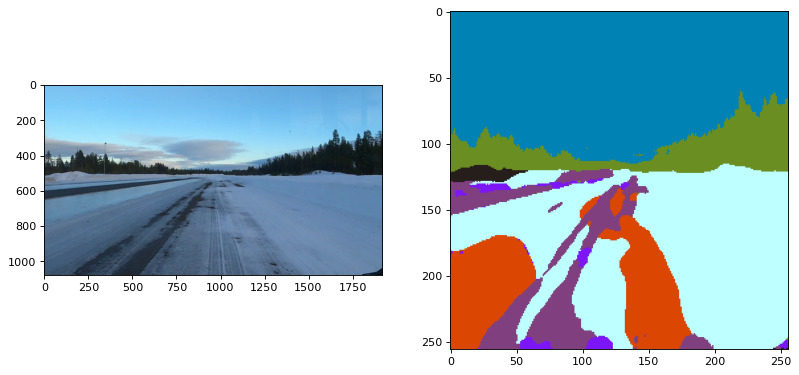

In [12]:
# plt.figure(figsize=(12, 10), dpi=80)

# f, axarr = plt.subplots(1,2, figsize=(12, 10), dpi=80)
# axarr[0].imshow(frame.permute(1,2,0))
# axarr[1].imshow(seg_color.squeeze(0).permute(1,2,0))

f, axarr = plt.subplots(1,2, figsize=(12, 10), dpi=80)
axarr[0].imshow(frame)
axarr[1].imshow(seg_color.squeeze(0).permute(1,2,0))


# plt.imshow(seg_color.squeeze(0).permute(1,2,0))
# plt.show()

(-0.5, 255.5, 255.5, -0.5)

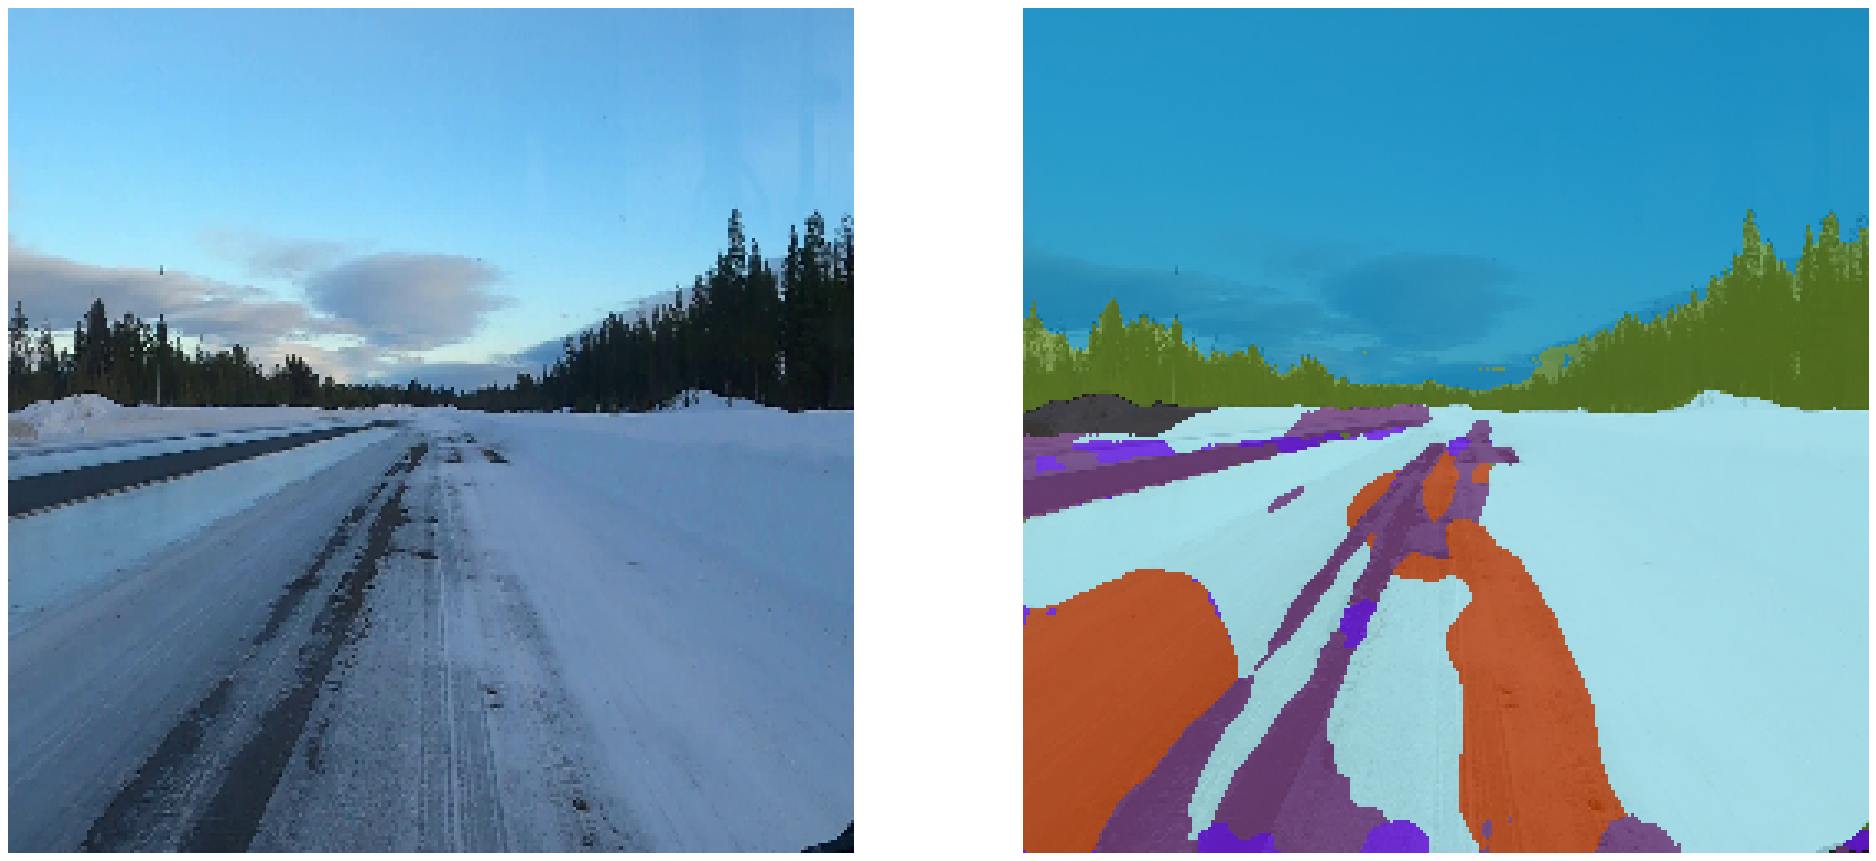

In [13]:
f, axarr = plt.subplots(1,2, figsize=(30, 28), dpi=80)
axarr[0].imshow(transform_ou(frame).permute(1,2,0))
# axarr[1].imshow(seg_color.squeeze(0).permute(1,2,0))
# frame_tmp = transforms.Resize((256,256))(frame)
axarr[1].imshow(0.3*transform_ou(frame).permute(1,2,0) + 0.7*(seg_color.squeeze(0).permute(1,2,0)).numpy())

axarr[0].axis('off')
axarr[1].axis('off')

# plt.savefig('seg.png', transparent=True)

In [14]:
for classId, (className, classColor) in enumerate(classIds.items()):
    
    masked = torch.where(torch.max(seg, axis = 0)[1]==classId, torch.max(seg, axis = 0)[0],0).squeeze(0)
    index = (masked != 0).nonzero(as_tuple=True)
#     axarr[1][1].plot([], [], color = np.array(classColor)/256., label= "{} : m {:.3f}, std {:.3f}".format(className, masked[masked>0].mean(), masked[masked>0].std()))

    
    if className not in ["sky", "vegetation", "void"]:
        maskedFri = torch.where(torch.max(seg, axis = 0)[1]==classId, fri.squeeze(), 0)
        mask = maskedFri != 0
        friMean = maskedFri.sum()/(mask.sum()+1e-15)
        friSTD = (fri - friMean) * (fri - friMean)
        friSTD = (friSTD.sum()/(mask.sum()+1e-15))**(0.5)

NameError: name 'fri' is not defined

In [17]:
segs = model.inference(transform_in(frame).unsqueeze(0))

In [18]:
segs[1]

{'dist1': Independent(Normal(loc: torch.Size([1, 6, 16, 16]), scale: torch.Size([1, 6, 16, 16])), 1),
 'dist2': Independent(Normal(loc: torch.Size([1, 6, 64, 64]), scale: torch.Size([1, 6, 64, 64])), 1),
 'dist3': Independent(Normal(loc: torch.Size([1, 6, 128, 128]), scale: torch.Size([1, 6, 128, 128])), 1)}